In [3]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns
import copy, time, matplotlib, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchsummary import summary

import torchvision
import torchvision.transforms as T

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# plt.rcParams.update({'font.size':11})

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Import libraries

In [1]:
# import all necessary modules
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym # to compute the partial derivatives

from IPython import display
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
''' Two possible strategies to avoid local minima
- One possible solution: Re-train the model many times using different random weights
(different starting locations on the loss landscape) and pick the model that does best.
- Another possible solution: Increase the dimensionality (complexity) of the model to have fewer local minima.
'''

# Gradient descent in 1D

In [1]:
# function (as a function)
def fx(x):
    return 3*x**2 - 3*x + 4

# derivative function
def deriv(x):
    return 6*x - 3

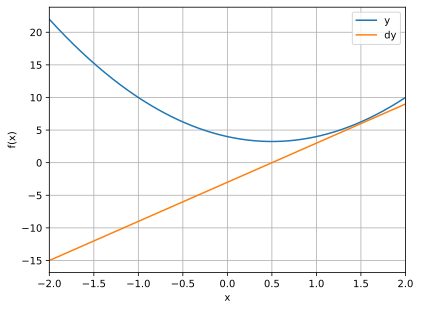

In [4]:
# plot the function and its derivative

# define a range for x
x = np.linspace(-2,2,2001)

# plotting
plt.plot(x, fx(x), x, deriv(x))
plt.xlim(x[[0,-1]])
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(['y', 'dy'])
plt.show()

In [6]:
# random starting point
local_min = np.random.choice(x,1)

# learning parameters
learning_rate = .01
training_epochs = 100

# run through training
for i in range(training_epochs):
    grad = deriv(local_min)
    local_min -= learning_rate*grad

local_min

array([0.49956437])

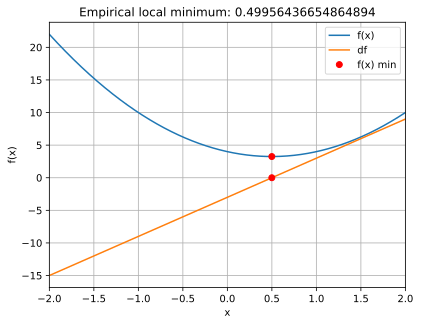

In [8]:
# plot the results
plt.plot(x, fx(x), x, deriv(x))
plt.plot(local_min, deriv(local_min), 'ro')
plt.plot(local_min, fx(local_min), 'ro')
plt.xlim(x[[0,-1]])
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(['f(x)', 'df', 'f(x) min'])
plt.title('Empirical local minimum: %s' % local_min[0])
plt.show()

## Store the model parameters and outputs on each iteration

In [ ]:
# random starting point
local_min = np.random.choice(x, 1)

# learning parameters
learning_rate = .01
training_epochs = 100

# run through training and store all the results
model_params = np.zeros((training_epochs,2))

for i in range(training_epochs):
    grad = deriv(local_min)
    local_min -= learning_rate * grad
    model_params[i, :] = local_min, grad

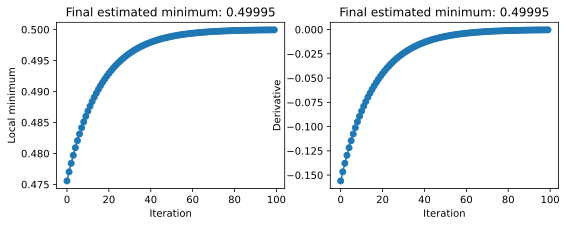

In [12]:
# plot the gradient over iterations
fig, ax = plt.subplots(1,2,figsize=(9,3))

for i in range(2):
    ax[i].plot(model_params[:,i], 'o-')
    ax[i].set_xlabel('Iteration')
    ax[i].set_title(f'Final estimated minimum: {local_min[0]:.5f}')

ax[0].set_ylabel('Local minimum')
ax[1].set_ylabel('Derivative')

plt.show()

# Gradient descent in 1D -  example 2

In [13]:
# function (as a function)
def fx(x):
    return np.cos(2*np.pi*x) + x**2

# derivative function
def deriv(x):
    return -2*np.pi*np.sin(2*np.pi*x) + 2*x

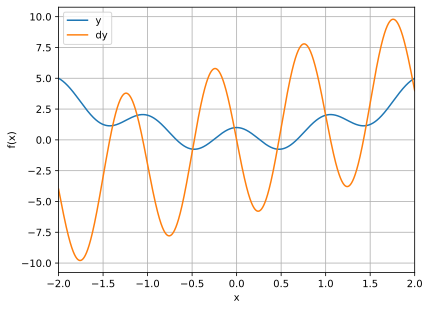

In [14]:
# plot the function and its derivative

# define a range for x
x = np.linspace(-2,2,2001)

# plotting
plt.plot(x, fx(x), x,deriv(x))
plt.xlim(x[[0,-1]])
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(['y', 'dy'])
plt.show()

In [19]:
# random starting point
local_min = np.random.choice(x, 1) # np.array([0])

# learning parameters
learning_rate = .01
training_epochs = 100

# run through training
for i in range(training_epochs):
    grad = deriv(local_min)
    local_min -= grad * learning_rate

local_min

array([-1.42506741])

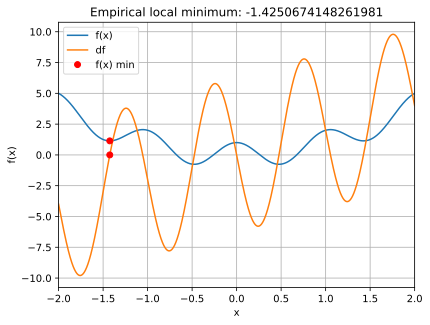

In [20]:
# plot the results
plt.plot(x, fx(x), x, deriv(x))
plt.plot(local_min, deriv(local_min), 'ro')
plt.plot(local_min, fx(local_min), 'ro')

plt.xlim(x[[0,-1]])
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(['f(x)','df', 'f(x) min'])
plt.title('Empirical local minimum: %s' % local_min[0])
plt.show()

# Gradient descent in 2D

In [2]:
# the "peaks" function
def peaks(x,y):
    # expand to a 2D mesh
    x,y = np.meshgrid(x,y)

    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2-y**2) - 1/3*np.exp(-(x+1)**2 - y**2)
    return z

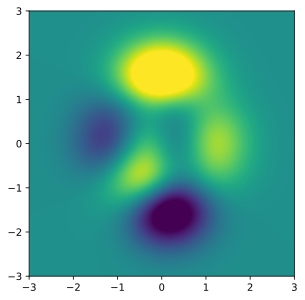

In [3]:
# create the landscape
x = np.linspace(-3,3,201)
y = np.linspace(-3,3,201)

Z = peaks(x,y)

# let's have a look!
plt.imshow(Z, extent=[x[0],x[-1],y[0],y[-1]], vmin=-5, vmax=5, origin='lower')
plt.show()

In [4]:
# create derivative functions using sympy
sx, sy = sym.symbols('sx, sy')

sZ = 3*(1-sx)**2 * sym.exp(-(sx**2) - (sy+1)**2) - 10*(sx/5 - sx**3 - sy**5) * sym.exp(-sx**2-sy**2) - 1/3*sym.exp(-(sx+1)**2 - sy**2)

# create functions from the sympy-computed derivatives
df_x = sym.lambdify( (sx, sy), sym.diff(sZ, sx), 'sympy')
df_y = sym.lambdify( (sx, sy), sym.diff(sZ, sy), 'sympy')

df_x(1,1).evalf()

-1.07369833656079

In [5]:
# random starting point (uniform between -2 and +2)
local_min = np.random.rand(2)*4-2 # also tray specifying coordinates
startpnt = local_min[:] # make a copy, not re-assign

# learning parameters
learning_rate = .01
training_epochs = 1000

# run through training
trajectory = np.zeros((training_epochs,2))
for i in range(training_epochs):
    grad = np.array([df_x(local_min[0], local_min[1]).evalf(), df_y(local_min[0], local_min[1]).evalf()])
    local_min = local_min + learning_rate * grad
    trajectory[i,:] = local_min

print(local_min)
print(startpnt)

[-0.00931758195995411 1.58136796293900]
[0.81003403 1.93561485]


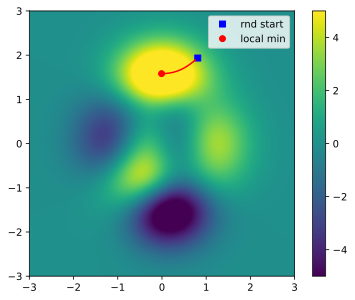

In [6]:
# let's have a look!
plt.imshow(Z, extent=[x[0],x[-1], y[0],y[-1]], vmin=-5, vmax=5, origin='lower')
plt.plot(startpnt[0], startpnt[1], 'bs')
plt.plot(local_min[0], local_min[1], 'ro')
plt.plot(trajectory[:,0], trajectory[:,1],'r')
plt.legend(['rnd start', 'local min'])
plt.colorbar()
plt.show()

# Parametric experiments on g.d.

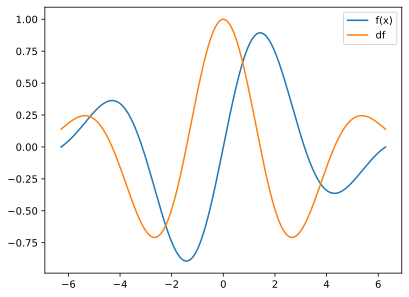

In [8]:
# the function
x = np.linspace(-2*np.pi, 2*np.pi, 401)
fx = np.sin(x) * np.exp(-x**2*.05)

# and it derivative
df = np.cos(x)*np.exp(-x**2*.05) + np.sin(x)*(-.1*x)*np.exp(-x**2*.05)

# quick plot for inspection
plt.plot(x, fx, x, df)
plt.legend(['f(x)', 'df']);

In [9]:
# function (note: over-writing variable names!)
def fx(x):
    return np.sin(x) * np.exp(-x**2*.05)

# derivative function
def deriv(x):
    return np.cos(x)*np.exp(-x**2*.05) + np.sin(x)*(-.1*x)*np.exp(-x**2*.05)

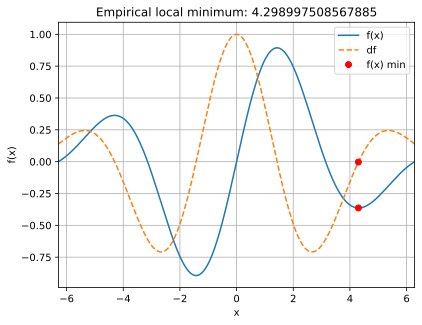

In [11]:
# random starting point
local_min = np.random.choice(x, 1)

# learning parameters
learning_rate = .01
trianing_epochs = 1000

# run through training
for i in range(training_epochs):
    grad = deriv(local_min)
    local_min -= learning_rate * grad

# plot the results
plt.plot(x, fx(x), x, deriv(x), '--')
plt.plot(local_min, deriv(local_min), 'ro')
plt.plot(local_min, fx(local_min), 'ro')

plt.xlim(x[[0,-1]])
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(['f(x)', 'df', 'f(x) min'])
plt.title('Empirical local minimum: %s' % local_min[0])
plt.show()

## Run parametric experiments

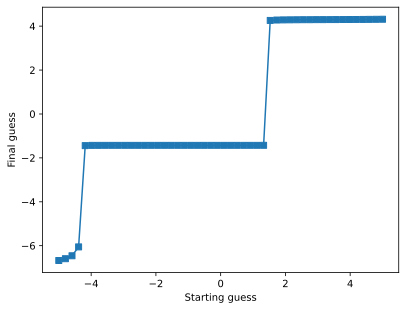

In [12]:
# Experiment 1: systematically varying the starting locations

start_locs = np.linspace(-5,5,50)
final_results = np.zeros(len(start_locs))

# loop over starting points
for idx, local_min in enumerate(start_locs):

    # run through training
    for i in range(training_epochs):
        grad = deriv(local_min)
        local_min -= learning_rate * grad

    # store the final guess
    final_results[idx] = local_min

# plot the results
plt.plot(start_locs, final_results, 's-')
plt.xlabel('Starting guess')
plt.ylabel('Final guess')
plt.show()

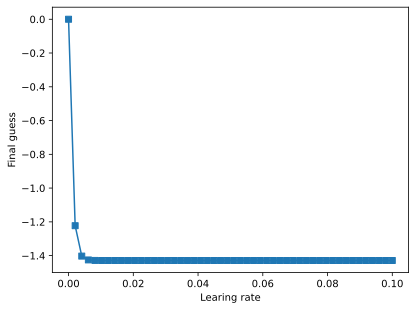

In [16]:
# Experiment 2: systematically varying the learning rate

learning_rates = np.linspace(1e-10, 1e-1, 50)
final_results = np.zeros(len(learning_rates))

# loop over learning rates
for idx, learningRate in enumerate(learning_rates):

    # force starting guess to 0
    local_min = 0

    # run through training
    for i in range(training_epochs):
        grad = deriv(local_min)
        local_min -= learningRate * grad

    # store the final guess
    final_results[idx] = local_min

# plot the results
plt.plot(learning_rates, final_results, 's-')
plt.xlabel('Learing rate')
plt.ylabel('Final guess')
plt.show()

In [17]:
# Experiment 3: interaction between learning rate and training epochs

# setup parameters
learning_rates = np.linspace(1e-10, 1e-1, 50)
training_epochs = np.round(np.linspace(10,500,40))

# initialize matrix to store results
final_results = np.zeros((len(learning_rates), len(training_epochs)))

# loop over learning rates
for Lidx, learningRate in enumerate(learning_rates):

    # loop over training epochs
    for Tidx, trainingEpochs in enumerate(training_epochs):

        # run through training (again fixing starting location)
        local_min = 0
        for i in range(int(trainingEpochs)):
            grad = deriv(local_min)
            local_min -= learningRate * grad

        # store the final guess
        final_results[Lidx, Tidx] = local_min

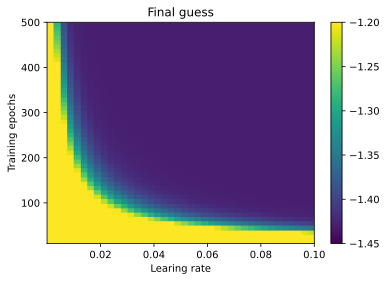

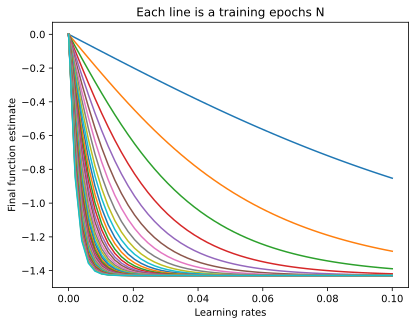

In [20]:
# plot the results
fig, ax = plt.subplots(figsize=(6,4))

plt.imshow(final_results, extent=[learning_rates[0], learning_rates[-1], training_epochs[0], training_epochs[-1]], \
           aspect='auto', origin='lower', vmin=-1.45, vmax=-1.2)
plt.xlabel('Learing rate')
plt.ylabel('Training epochs')
plt.title('Final guess')
plt.colorbar()
plt.show()

# another visualization
plt.plot(learning_rates, final_results)
plt.xlabel('Learning rates')
plt.ylabel('Final function estimate')
plt.title('Each line is a training epochs N')
plt.show()

# Fixed vs. dynamic learning rate

## Create the function and its derivative

In [21]:
# define a range for x
x = np.linspace(-2,2,2001)

# function
def fx(x):
    return 3*x**2 - 3*x + 4

# derivative function
def deriv(x):
    return 6*x - 3

## G.D. using a fixed learning rate

In [32]:
# random starting point
local_min = np.random.choice(x, 1)
init_val = local_min[:] # store the initial value

# learning parameters
learning_rate = .01
training_epochs = 50

# run through training and store all the results
modelparamsFixed = np.zeros((training_epochs,3))

for i in range(training_epochs):

    # compute gradient
    grad = deriv(local_min)

    # non-adaptive learning rate
    lr = learning_rate

    # update parameter according to g.d.
    local_min -= lr * grad

    # store the parameters
    modelparamsFixed[i, :] = local_min, grad, lr

<ipython-input-32-f58e947cd497>:24: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  modelparamsFixed[i, :] = local_min, grad, lr


## G.D. using a gradient-based learning rate

In [33]:
# random starting point
local_min = np.random.choice(x, 1)
init_val = local_min[:]

# learning parameters
learning_rate = .01
training_epochs = 50

# run through training and store all the results
modelparamsGrad = np.zeros((training_epochs, 3))

for i in range(training_epochs):

    # compute gradient
    grad = deriv(local_min)

    # adaptive learning rate according to the gradient
    lr = learning_rate * np.abs(grad)

    # update parameter according to g.d.
    local_min -= lr * grad

    # store the parameters
    modelparamsGrad[i, :] = local_min, grad, lr

<ipython-input-33-ea547ab0e076>:24: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  modelparamsGrad[i, :] = local_min, grad, lr


## G.D. using a time-based learning rate

In [34]:
# redefine parameters
learning_rate = .1
local_min = init_val

# run through training and store all the results
modelparamsTime = np.zeros((training_epochs, 3))

for i in range(training_epochs):

    grad = deriv(local_min)

    lr = learning_rate * (1-(i+1)/training_epochs)

    local_min -= lr * grad

    modelparamsTime[i,0] = local_min
    modelparamsTime[i,1] = grad
    modelparamsTime[i,2] = lr

## Plot the results

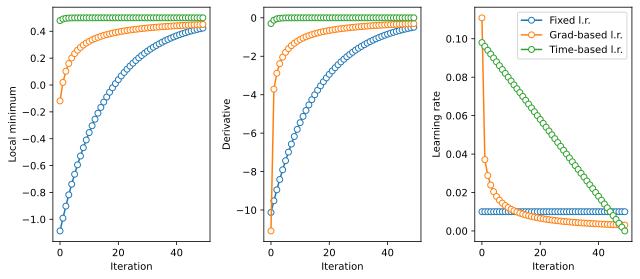

In [35]:
fig, ax = plt.subplots(1,3,figsize=(9,4))

# generate the plots
for i in range(3):
    ax[i].plot(modelparamsFixed[:,i], 'o-', markerfacecolor='w')
    ax[i].plot(modelparamsGrad[:,i], 'o-', markerfacecolor='w')
    ax[i].plot(modelparamsTime[:,i], 'o-', markerfacecolor='w')
    ax[i].set_xlabel('Iteration')

ax[0].set_ylabel('Local minimum')
ax[1].set_ylabel('Derivative')
ax[2].set_ylabel('Learning rate')
ax[2].legend(['Fixed l.r.', 'Grad-based l.r.', 'Time-based l.r.'])

plt.tight_layout()
plt.show()

In [ ]:
''' Possible ways to proportionate the learning rate:

1) Training epoch: Good method, often done in blocks. But unrelated to model performance/accuracy.
=> "learning rate decay"

2) Derivative: Adaptive to the problem. Requires additional parameters and appropriate scaling.
=> "RMSprop and Adam optimizers"

3) Loss: Adaptive to the problem. Works only when loss is in range of [0,1] (scaling possible).

4) Current local minimum value: Adaptive to the problem. Too many assumptions for this generally to be a good idea.
'''

# Vanishing and exploding gradients

In [ ]:
''' How to minimize gradient problems

- Use models with few hidden layers.
- Use activation functions that do not saturate (e.g., ReLU).
- Apply weight normalization.
- Pre-train networks using autoencoders.
- Use regularization techniques like batch normalization, dropout, and weight decay.
- Use architectures like residual networks ("resnet").

'''